In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from src import *
from utils import NatConst
import gc

In [2]:
""" 
Define natural constants
"""
nat_const = NatConst()

"""
Define the ion chain 
"""
N_ion = 2
MOD_params_dim = [3, 3, 3, 3]   # n_1 to n_4
MOD_params_sec = [1.8e6, 2e6, 2.2e6, 2.4e6]   # Hz

# [axis 1 ion 1, axis 1 ion 2, axis 2 ion 1, axis 2 ion 2]
Chain_theta = np.pi/4
MOD_params_nm = [
    [np.cos(Chain_theta), -np.cos(Chain_theta), np.sin(Chain_theta), -np.sin(Chain_theta)],
    [np.cos(Chain_theta), np.cos(Chain_theta), np.sin(Chain_theta), np.sin(Chain_theta)],
    [np.sin(Chain_theta), -np.sin(Chain_theta), np.cos(Chain_theta), -np.cos(Chain_theta)],
    [np.sin(Chain_theta), np.sin(Chain_theta), np.cos(Chain_theta), np.cos(Chain_theta)]
]

MOD_params_gamma_heating = [0,0,0,0]
MOD_params_gamma_dephasing = [0,0,0,0]
MOD_params_bath_mean_n = [0,0,0,0]
MOD_params_dict = {"dim": MOD_params_dim, "secular": MOD_params_sec, "n-mode": MOD_params_nm,
                   "heating": MOD_params_gamma_dephasing, "dephasing": MOD_params_gamma_dephasing,
                   "mean_n": MOD_params_bath_mean_n}

'''
N_ion = 1
MOD_params_dim = [5, 5]   # n_21, n_22
MOD_params_sec = [1.8e6, 2.1e6]   # Hz
MOD_params_nm = [
    [-0.7071067811865475, 0.7071067811865475], 
    [0.7071067811865475, 0.7071067811865475]
]
MOD_params_gamma_heating = [0,0]
MOD_params_gamma_dephasing = [0,0]
MOD_params_bath_mean_n = [0,0]
MOD_params_dict = {"dim": MOD_params_dim, "secular": MOD_params_sec, "n-mode": MOD_params_nm,
                   "heating": MOD_params_gamma_dephasing, "dephasing": MOD_params_gamma_dephasing,
                   "mean_n": MOD_params_bath_mean_n}
'''

chain_instance = ChainAPI(N_ion, MOD_params_dict)

"""
Initialize the quantum state of the ion chain 
"""
INIT_dist = "thermal"   # thermal, non-thermal
INIT_params_mod = [[0, 0],  # n_11, n_12
                   [0, 0]]  # n_21, n_22
INIT_params_tls = [[1, 0], [1, 0]]   # tls_1, tls_2
# INIT_params_mod = [[0.0],
#                    [0.0]]
# INIT_params_tls = [[1, 0]]   # tls_1, tls_2

chain_instance.init_sim_array(INIT_dist, INIT_params_mod, INIT_params_tls)

""" 
Define the external signals
"""
EXT_SIG_on_ion = dict()
for i in range(N_ion):
    EXT_SIG_on_ion[i] = ExtSigAPI(i)

for i in range(N_ion):
    EXT_SIG_on_ion[i].set_laser_params_config([355, "counter", np.pi/2])

EXT_SIG_on_ion[0].set_laser_params_rabi(["constant", [100E3, 100E3]])
EXT_SIG_on_ion[1].set_laser_params_rabi(["constant", [100E3, 100E3]])

# MS interaction
detun_val = 2.05e6
EXT_SIG_on_ion[0].set_laser_params_detuning(["constant", [detun_val, -detun_val]])
EXT_SIG_on_ion[1].set_laser_params_detuning(["constant", [detun_val, -detun_val]])

Base simulation array created: N_TLS = 2, N_MOD = 4, dimensions [4 4 4 4 4 4 4 4 2 2 2 2]
[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0]]


In [3]:
"""
Instantiate the simulator 
"""
simulator = RunSim()
simulator.construct_ion_chain(chain_instance)
simulator.set_external_signal(EXT_SIG_on_ion)
"""
Consturct matrices
"""
simulator.construct_propagator_K()
simulator.construct_dissipator_J()
"""
Execute simulation
"""
simulator.execute_evolution(t_tot=500e-6, dt=25e-9, dev='cuda')

Use NVIDIA GeForce RTX 3090 Ti
Set device to NVIDIA GeForce RTX 3090 Ti
Construct K matrix
Construct J matrix
Start simulation


  0%|          | 0/3999 [00:00<?, ?it/s]

In [4]:
"""
Instantiate the simulator 
"""
simulator_cpu = RunSim()
simulator_cpu.construct_ion_chain(chain_instance)
simulator_cpu.set_external_signal(EXT_SIG_on_ion)
"""
Consturct matrices
"""
simulator_cpu.construct_propagator_K()
simulator.construct_dissipator_J()
"""
Execute simulation
"""
simulator_cpu.execute_evolution(t_tot=100e-6, dt=25e-9, dev='cpu')

Set device to cpu
Construct K matrix
Construct J matrix
Start simulation


  0%|          | 0/3999 [00:00<?, ?it/s]

KeyboardInterrupt: 

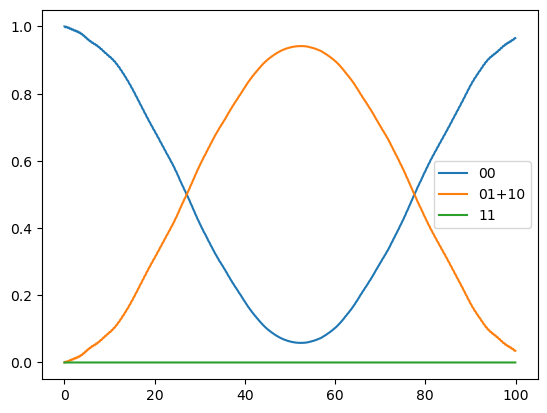

In [ ]:
population = np.array([simulator.ION_CHAIN.partial_trace(simulator.sim_timeline['density'][i], [4,5])
                       for i in range(len(simulator.sim_timeline['density']))])

idx1, idx2 = 0, 0
plt.plot(np.array(simulator.sim_timeline['time_step'])*1e6, population[:,idx1,idx1,idx2,idx2], label='00')
idx1, idx2 = 0, 1
plt.plot(np.array(simulator.sim_timeline['time_step'])*1e6, population[:,idx1,idx1,idx2,idx2] + population[:,idx2,idx2,idx1,idx1], label='01+10')
idx1, idx2 = 1, 1
plt.plot(np.array(simulator.sim_timeline['time_step'])*1e6, population[:,idx1,idx1,idx2,idx2], label='11')
plt.legend(loc='best')
plt.show()